# Custom

In [1]:
import sympy as sp
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt #gráficas
import matplotlib as mpl
import seaborn as sns #gráficas
plt.style.use('ggplot') #estilo de graficas

In [2]:
data = pd.read_excel('data/cement_data.xlsx', sheet_name='Sheet1')
data.pop(data.columns[0]);
data.loc[:, 'Tipo Cemento'] = data['Tipo Cemento'].map(lambda s:'UEM' if s == 1 else 'IND') # Cement type map: {0,1} -> {IND, UEM}
data_UEM = data[data['Tipo Cemento'] == 'UEM'].reset_index(drop=True)

In [3]:
def train_test_data(data: 'df', prop: int, seed: int) -> '(df, df)':
    train = data.sample(frac=prop, random_state=seed)
    test = data.drop(train.index)
    return train, test

def retrieveXY(train: 'df', test: 'df', x_vars: list, y_var: str) -> '(df, df, df, df)':
    x_train = train[x_vars]
    y_train = train[y_var]
    x_test = test[x_vars]
    y_test = test[y_var]
    return x_train, y_train, x_test, y_test

def to_listXY(X: 'df', Y: 'df') -> '(list, list)':
    X_list = [X.iloc[:,i].tolist() for i in range(X.shape[1])]
    Y_list = Y.iloc[:].tolist()
    return X_list, Y_list

In [4]:
train, test = train_test_data(data_UEM, prop=0.1, seed=25)
X_train, Y_train, X_test, Y_test = retrieveXY(train, test, ['Tiempo', 'EA', 'F Inicial'], 'Resistencia')
x_train, y_train = to_listXY(X_train, Y_train)
x_test, y_test = to_listXY(X_test, Y_test)

In [5]:
from sympy import symbols, init_printing, Function, sympify, Derivative, simplify, ordered
from sympy import factorial, Matrix, prod
init_printing(use_latex='mathjax') # Printing preferences
import itertools

def Taylor_polynomial_sympy(function_expression: 'symbolic', variable_list: list, evaluation_point: list, degree: int) -> 'symbolic':

  n_var = len(variable_list)
  point_coordinates = [(i, j) for i, j in (zip(variable_list, evaluation_point))]  # list of tuples with variables and their evaluation_point coordinates, to later perform substitution

  deriv_orders = list(itertools.product(range(degree + 1), repeat=n_var))  # list with exponentials of the partial derivatives
  deriv_orders = [deriv_orders[i] for i in range(len(deriv_orders)) if sum(deriv_orders[i]) <= degree]  # Discarding some higher-order terms
  n_terms = len(deriv_orders)
  deriv_orders_as_input = [list(sum(list(zip(variable_list, deriv_orders[i])), ())) for i in range(n_terms)]  # Individual degree of each partial derivative, of each term

  polynomial = 0
  for i in range(n_terms):
    partial_derivatives_at_point = function_expression.diff(*deriv_orders_as_input[i]).subs(point_coordinates)  # e.g. df/(dx*dy**2)
    denominator = prod([factorial(j) for j in deriv_orders[i]])  # e.g. (1! * 2!)
    distances_powered = prod([(Matrix(variable_list) - Matrix(evaluation_point))[j] ** deriv_orders[i][j] for j in range(n_var)])  # e.g. (x-x0)*(y-y0)**2
    polynomial += partial_derivatives_at_point / denominator * distances_powered
  return polynomial



def Model_taylor_sympy(taylor_serie: 'symbolic') -> (['symbolic'], ['symbolic']):

  # Convert Serie to list
  S = list(sympify((sympify(taylor_serie, evaluate=False)).args))
  M = S.copy() # Copy the list to use for the model

  # Check for derivatives
  # Substitue derivatives from Serie List with parameters (cleaner than from Serie)
  d = [list(i.atoms(Derivative)) for i in M]
  d_unpacked = [x for l in d for x in l] # this unpacks it but gets messy if a list had more than 1 element
  
  # if d_unpacked is empty it means there are no derivatives in the serie
  A = [];

  if len(d_unpacked) != 0:  # if there are derivatives
    indexes = [idx for idx in range(len(d)) if len(d[idx])] # Get indexes

    for i in indexes:
      A_aux = sympify(['a' + str(_) for _ in range(len(A), len(A) + 1)])
      A += A_aux
      M[i] = simplify(M[i].subs(list(ordered(d[i]))[0], A_aux[0]))
    
    # Clean the f(c) termn at the end
    A_aux = sympify(['a' + str(_) for _ in range(len(A), len(A) + 1)])
    A += A_aux
    M[-1] = A_aux[0]
  
  return M, A

In [254]:
# Model F(x1, x2, ..., xn) where n is n_vars

n_vars = X_train.shape[1] # Num of variables = num of columns
vars = sp.symbols('x0:'+str(n_vars)) # List of variables
center = [0]*len(vars)

f = Function('f')
fun = f(sum(vars)) # f(x1+x2+...+xn)
deg = 2

F = Taylor_polynomial_sympy(fun, vars, center, deg)

# Generate the model
M, A = Model_taylor_sympy(F)

In [255]:
# Display results
display(A) # List of all parameters

# Convert list back to sum
model = sum(M)
display(model)

[a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, a₉]

                             2        2        2                              
                        a₃⋅x₀    a₄⋅x₁    a₅⋅x₂                               
a₀⋅x₀ + a₁⋅x₁ + a₂⋅x₂ + ────── + ────── + ────── + a₆⋅x₀⋅x₁ + a₇⋅x₀⋅x₂ + a₈⋅x₁
                          2        2        2                                 

        
        
⋅x₂ + a₉
        

In [257]:
par = list(vars) + A
display(par) # Order of function parameters
fun = sp.lambdify(par, model, 'numpy')

[x₀, x₁, x₂, a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, a₉]

In [259]:
A

[a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, a₉]

In [493]:
import random
np.random.seed(42)

# array: np.array, [list, ..., list], list

def generate_population(P_size: 'tuple', method: str, bounds: list, names: list, plot=False) -> 'array':
  '''
  P_size: (individuos, parámetros)
  method: 'uniform', 'saltelli'
  bounds: 'uniform': [lower, upper], 'saltelli': [bound1, bound2, ..., boundn]
  plot: True or False, visualize parameter space
  names: list of parameter names ['a0', 'a1', ... 'an']
  '''
  from SALib.sample import saltelli, sobol_sequence
  import warnings
  warnings.filterwarnings("ignore")

  if method == 'uniform':
    l, h = bounds
    P = np.random.uniform(low=l, high=h, size=P_size) # Initial population

  if method == 'saltelli':
    problem ={'num_vars': P_size[1], 'names': names, 'bounds': [bounds]*P_size[1]}
    
    N = max(2**P_size[1], P_size[0])
    
    P = saltelli.sample(problem, N)
    P = pd.DataFrame(P)
    P = P.sample(P_size[0])
    P = P.values
  
  if method == 'sobol':
    l, h = bounds
    P = sobol_sequence.sample(*P_size) # range is in [0,1]
    P = l + (h-l)*P # Transform to range [l, h] = bounds
  
  if plot == True:
    P_dist = pd.DataFrame(P)
    P_dist.columns = names
    g = sns.pairplot(P_dist);
    g.fig.set_size_inches(8,8);
    
  return P.tolist()

def mse(A: 'array', B: 'array') -> float: # Cleanest way to calculate MSE
  return np.square(np.subtract(A, B)).mean()

def fitness(X: 'array', Y: list, P: 'array', fun: 'function') -> list:
  '''
  X = [X1, X2, ..., Xn]: observations of predictors
  Y: observations of variable of interest
  P = [theta1, theta2, ..., thetan]: population (possible parameters)
  '''
  Y_bar = [[fun(*[item[i] for item in X], *P[j]) for i in range(len(X[0]))] for j in range(len(P))]
  fitness = [mse(Y_bar[i], Y) for i in range(len(P))]
  return fitness, Y_bar

def selection(P: 'array', fitness: list, num: int) -> 'array':
  return random.choices(population=P, weights=fitness, k=num)

def crossover(x: list, y: list) -> list: # Single point
  offspring = np.mean([x, y], axis=0)
  return offspring.tolist()

def mutation(P: 'array') -> list:
  min_P = np.array(min(P))
  max_P = np.array(max(P))
  rang = max_P - min_P
  x = rang*np.random.uniform(-2.0, 2.0) # Uniform mutation
  return x.tolist()
  
def candidates(P: 'array', num: int) -> '(list, list, list)':
  cand = [i for i in range(len(P)) if i != j]
  P = np.array(P)
  c = P[np.random.choice(cand, num, replace=False)]
  return c.tolist()

def DE_mutation(P: 'array', F: int) -> list:
  P = np.array(P)
  c = candidates(P, 3)
  x = c[0] + F * (c[1] - c[2])
  return x.tolist()

def printer(current_time, i, fit):
  minutes = round((current_time // 60) % 60, 0)
  seconds = round(current_time % 60, 0)
  print('Generation: ', str(i))
  print('time: ', int(minutes), "m", int(seconds), "s")
  print(f'Fitness: {fit[0]}')

def local_search(X: 'array', Y: list, P: 'array') -> list:
  best = P[0]
  best = np.array([best]*len(best))
  for i in range(len(best)):
    best[i][i] = -1*best[i][i]
  best = best.tolist()
  fit, _ = fitness(X,Y,best,fun)
  best = [a for _, a in sorted(zip(fit, best))]
  index = [a < b for (a,b) in zip(best, P)]
  index = [i for i in range(len(index)) if index[i]]

  P = np.array(P)
  best = np.array(best)

  P[index] = best[index]
  P = P.tolist()
  return P
  

In [494]:
def fun(x0, x1, x2, a0, a1, a2, a3, a4, a5, a6):
  y = a0*x0 + a1*x1 + a2*x2 + a3*x0**2 + a4*x1**2 + a5*x2**2  + a6
  return y

# Inputs of the equation
X = x_train

# Compressive Strength
Y = y_train

# P = generate_population(P_size=(50,len(A)), method='saltelli', bounds=[-40,40], names=[str(i) for i in A], plot=False)
P = generate_population(P_size=(100,7), method='saltelli', bounds=[-40,40], names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6'], plot=False)

In [495]:
import time

generations = 100
start = time.time()
count = 0

for i in range(generations):
  fit, _ = fitness(X,Y,P,fun)
  P = [a for _, a in sorted(zip(fit, P))] # Ordena la población de menor a mayor fitness

  mid = int(len(P) / 2)
  parents = selection(P, fit, mid) # Selección de los padres
  x = [crossover(parents[i], parents[i+1]) for i in range(len(parents)-1)] # Cruce, obtención de los hijos
  y = candidates(P, mid) # Se seleccionan uniformemente mid candidatos para mutación
  y = [mutation(y) for _ in range(len(y))] # Mutación

  P_ng = P + x + y
  fit, Y_bar = fitness(X,Y,P_ng,fun)
  P_ng = [a for _, a in sorted(zip(fit, P_ng))] # Ordena la población de menor a mayor fitness
  P = P_ng[0:len(P)] # Actualiza la población y mantiene su tamaño original

  if P_ng[0] == P[0]:
    count += 1
  else:
    count = 0
  
  if count == 10:
    P = local_search(X, Y, P) # Búsqueda local
    print('LOCAL SEARCH')
    count = 0

  current_time = time.time()-start
  printer(current_time, i, fit)

print(f'best solution: {P[0]}')
print(f'Fitness: {fit[0]}')
# print(f'Y_hat: {Y_bar[0]}')

Generation:  0
time:  0 m 0 s
Fitness: 61720842.77706253
Generation:  1
time:  0 m 0 s
Fitness: 21857.85257843282
Generation:  2
time:  0 m 1 s
Fitness: 21857.85257843282
Generation:  3
time:  0 m 1 s
Fitness: 21857.85257843282
Generation:  4
time:  0 m 1 s
Fitness: 21857.85257843282
Generation:  5
time:  0 m 2 s
Fitness: 21857.85257843282
Generation:  6
time:  0 m 2 s
Fitness: 21857.85257843282
Generation:  7
time:  0 m 2 s
Fitness: 4490.908975214923
Generation:  8
time:  0 m 3 s
Fitness: 4490.908975214923
LOCAL SEARCH
Generation:  9
time:  0 m 3 s
Fitness: 4490.908975214923
Generation:  10
time:  0 m 3 s
Fitness: 428.0140944414206
Generation:  11
time:  0 m 3 s
Fitness: 428.0140944414206
Generation:  12
time:  0 m 4 s
Fitness: 428.0140944414206
Generation:  13
time:  0 m 4 s
Fitness: 121.9757347093295
Generation:  14
time:  0 m 4 s
Fitness: 121.9757347093295
Generation:  15
time:  0 m 5 s
Fitness: 121.9757347093295
Generation:  16
time:  0 m 5 s
Fitness: 121.9757347093295
Generation:

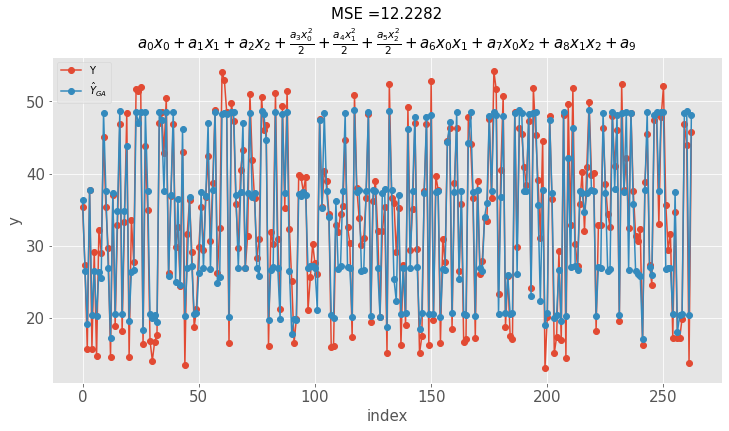

In [496]:
mse_GA = mse(Y_bar[0],Y)
T = list(range(len(Y)))

# Plot data and results
plt.figure(figsize = (12, 6));
plt.plot(T, Y, '-o', label='Y')
plt.plot(T, Y_bar[0], '-o', label='$\hat{Y}_{GA}$')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('index', fontsize = 15);
plt.ylabel('y', fontsize = 15);
plt.legend()
plt.title('MSE =' + str(round(mse_GA, 4)) + '\n' + '$'+f'{sp.latex(model)}'+'$', fontsize = 15);

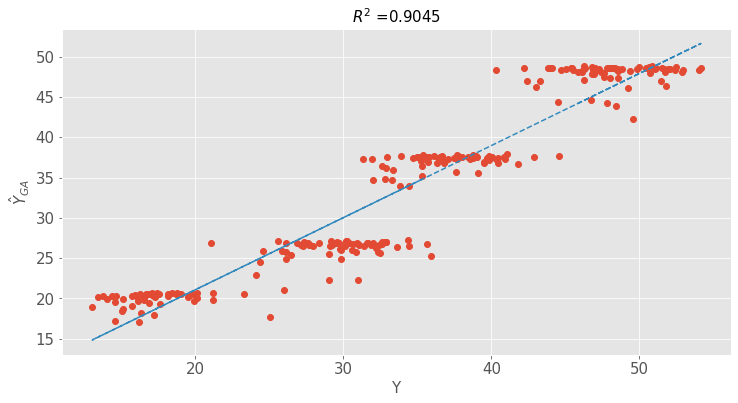

In [497]:
plt.figure(figsize = (12, 6));
plt.plot(Y, Y_bar[0], 'o')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Y', fontsize = 15);
plt.ylabel('$\hat{Y}_{GA}$', fontsize = 15);
RES = sum([(Y[i] - Y_bar[0][i])**2 for i in range(len(Y))]) # residual error
TOT = sum([(Y[i] - np.mean(Y))**2 for i in range(len(Y))]) # total error
R2 = 1-(RES/TOT) # definition of R2 metric
plt.title('$R^2$ =' + str(round(R2, 4)), fontsize = 15);

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(Y, Y_bar[0], 1);

#add linear regression line to scatterplot 
plt.plot(Y, [m*i+b for i in Y], '--');

# Fit

In [498]:
from scipy.optimize import curve_fit

def Euler(x, a0, a1, a2, a3, a4, a5, a6):
    x = np.array(x)
    y = a0*x[0] + a1*x[1] + a2*x[2] + a3*x[0]**2 + a4*x[1]**2 + a5*x[2]**2  + a6
    return y

parameters, covariance = curve_fit(Euler, x_train, y_train)
parameters

array([ 3.91813156e+00,  2.24353890e+01, -2.66519724e-01, -9.88964859e-02,
       -2.61198238e+01,  9.06381297e-04,  3.04930297e+01])

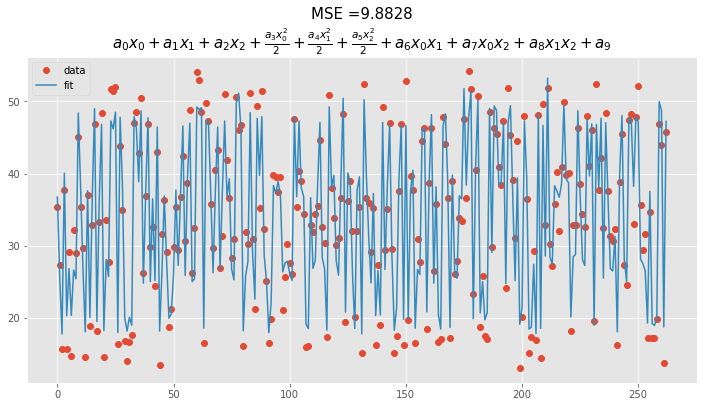

In [499]:
fit_y = Euler(x_train, *parameters)
T = list(range(len(fit_y)))
mse_fit = mse(fit_y,y_train)

plt.figure(figsize=(12,6))
plt.plot(T, y_train, 'o', label='data')
plt.plot(T, fit_y, '-', label='fit')
plt.title('MSE =' + str(round(mse_fit, 4)) + '\n' + '$'+f'{sp.latex(model)}'+'$', fontsize = 15);
plt.legend();

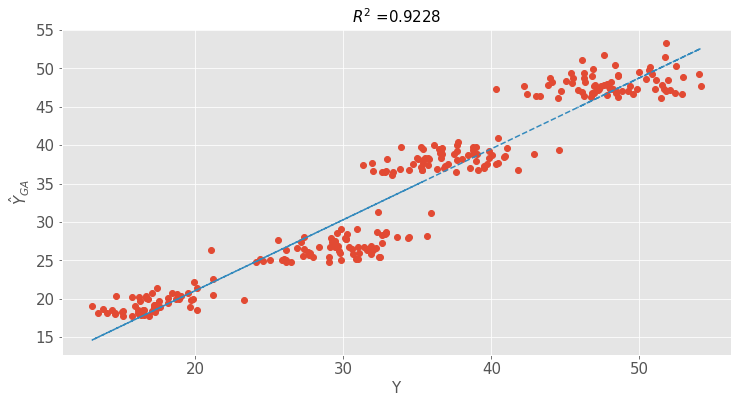

In [500]:
# Plot model fit

plt.figure(figsize = (12, 6));
plt.plot(y_train, fit_y, 'o')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('Y', fontsize = 15);
plt.ylabel('$\hat{Y}_{GA}$', fontsize = 15);
RES = sum([(y_train[i] - fit_y[i])**2 for i in range(len(y_train))]) # residual error
TOT = sum([(y_train[i] - np.mean(y_train))**2 for i in range(len(y_train))]) # total error
R2 = 1-(RES/TOT) # definition of R2 metric
plt.title('$R^2$ =' + str(round(R2, 4)), fontsize = 15);

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_train, fit_y, 1);

#add linear regression line to scatterplot 
plt.plot(y_train, [m*i+b for i in y_train], '--');